In [1]:
import copy
from pathlib import Path
import warnings
import sys
import os

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
from tqdm.autonotebook import tqdm
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
# Add the path to your DataPreprocessor.py file
sys.path.append(os.path.abspath("../Data_preprocessing"))

from DataPreprocessor import DataPreprocessor

# Now you can use the DataPreprocessor class as intended


In [3]:
preprocessing = DataPreprocessor()
visitor_data = pd.read_csv("./data/BesucherMessungExport.csv")
meteo_csv_directory = "./data/exogen_data"
merged_visitor_meteo_dataframes = preprocessing.get_merged_visitor_meteo_data(visitor_data, meteo_csv_directory=meteo_csv_directory, prepare_for_ml=True)
data = merged_visitor_meteo_dataframes["Hertensteinstrasse"]

In [4]:
data['time_idx'] = range(1, len(data) + 1)
data["group_id"] = 0  # Alle Daten in einer Gruppe
data

,time,visitors,Air Pressure (hPa),Precipitation (mm),Air Temperature (°C),Precipitation Duration (min),Snow Depth (cm),Sunshine Duration (min),Wind Speed (km/h),Absolute Humidity (g/m³),time_idx,group_id
40304,2023-12-06 13:00:00,1.284389,-0.176602,-0.23331,-1.095958,-0.384879,7.131158,4,0.799559,-1.282522,1,0
40305,2023-12-06 13:10:00,1.253064,-0.176602,-0.23331,-1.121515,-0.384879,7.131158,4,0.198980,-1.308833,2,0
40306,2023-12-06 13:20:00,1.350159,-0.161979,-0.23331,-1.108737,-0.384879,7.131158,0,0.198980,-1.282522,3,0
40307,2023-12-06 13:30:00,1.350159,-0.147356,-0.23331,-1.108737,-0.384879,7.131158,0,0.198980,-1.282522,4,0
40308,2023-12-06 13:40:00,1.511581,-0.132733,-0.23331,-1.147073,-0.384879,7.131158,0,-0.584835,-1.308833,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
82269,2024-09-22 23:10:00,-1.413636,-0.366703,-0.23331,0.041335,-0.384879,-0.140223,0,-0.139776,0.453966,21568,0
82270,2024-09-22 23:20:00,-1.413636,-0.352080,-0.23331,0.041335,-0.384879,-0.140223,0,-0.032556,0.427655,21569,0
82271,2024-09-22 23:30:00,-1.413636,-0.366703,-0.23331,0.028556,-0.384879,-0.140223,0,-0.291392,0.453966,21570,0
82272,2024-09-22 23:40:00,-1.413636,-0.366703,-0.23331,0.028556,-0.384879,-0.140223,0,-0.454249,0.453966,21571,0


In [5]:
max_prediction_length = 6 # eine Stunde
max_encoder_length = 24 # 4 Stunden
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="visitors",
    group_ids=["group_id"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=[
        "Air Pressure (hPa)", "Precipitation (mm)", "Air Temperature (°C)", 
        "Precipitation Duration (min)", "Snow Depth (cm)", "Sunshine Duration (min)", 
        "Wind Speed (km/h)", "Absolute Humidity (g/m³)"
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [6]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

/tmp/ipykernel_20215/2174382858.py:2: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
/home/jovyan/.local/share/virtualenvs/TFT-hjs_SVFO/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/jovyan/.l

tensor(0., device='cuda:0')

In [7]:
from torch.optim import Adam

pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Adam"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 9.8k


/home/jovyan/.local/share/virtualenvs/TFT-hjs_SVFO/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/jovyan/.local/share/virtualenvs/TFT-hjs_SVFO/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01584893192461113
Restoring states from the checkpoint path at /home/jovyan/BAA/TFT/.lr_find_aae5b380-a781-4b4b-8134-df2403a1c957.ckpt
Restored all states from the checkpoint at /home/jovyan/BAA/TFT/.lr_find_aae5b380-a781-4b4b-8134-df2403a1c957.ckpt


suggested learning rate: 0.01584893192461113


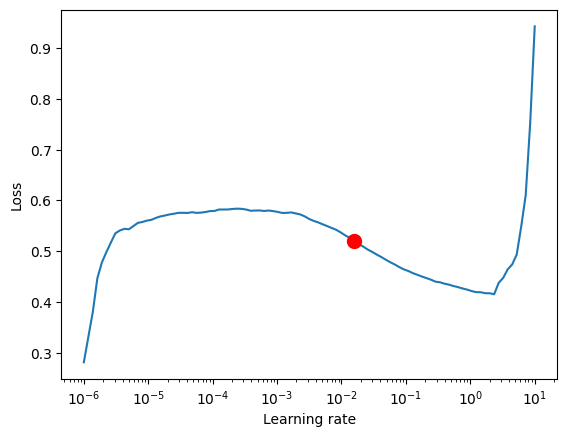

In [8]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner
import warnings
warnings.filterwarnings("ignore")
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [9]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Adam",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 23.4k


In [10]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 208    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.6 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [12]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=3,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)
# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)
# show best hyperparameters
print(study.best_trial.params)

[I 2024-10-29 11:55:48,193] A new study created in memory with name: no-name-6949a972-a4cc-4de0-bf69-1dba1a8d6d77
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-10-29 12:06:00,393] Trial 0 finished with value: 0.2380194067955017 and parameters: {'gradient_clip_val': 0.15586528523972212, 'hidden_size': 77, 'dropout': 0.17734880135651354, 'hidden_continuous_size': 14, 'attention_head_size': 2, 'learning_rate': 0.019414647701837717}. Best is trial 0 with value: 0.2380194067955017.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-10-29 12:16:00,423] Trial 1 finished with value: 0.5931231379508972 and parameters: {'gradient_clip_val': 0.012202556673230445, 'hidden_

{'gradient_clip_val': 0.15586528523972212, 'hidden_size': 77, 'dropout': 0.17734880135651354, 'hidden_continuous_size': 14, 'attention_head_size': 2, 'learning_rate': 0.019414647701837717}


In [17]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)

best_hyperparameters = {
    "gradient_clip_val": 0.4727,
    "hidden_size": 23,
    "dropout": 0.1321,
    "hidden_continuous_size": 17,
    "attention_head_size": 4,
    "learning_rate": 0.0010
}
best_model_path = trainer.checkpoint_callback.best_model_path

best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [18]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.5567, device='cuda:0')

In [15]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


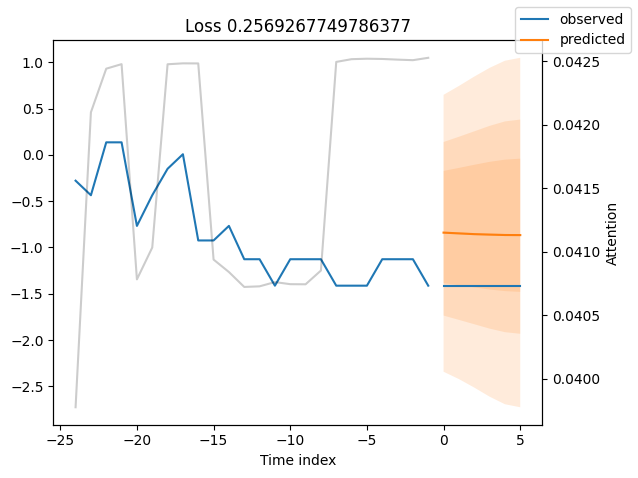

In [21]:
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)